In [1]:
import polars as pl
import glob
import os

In [2]:
# Take a chunk of monthly data in 2009
saved_folder = r"C:\Users\ekadw\Documents\GitHub\DATA\streaming_in_polars"

In [3]:
data_jan_5000 = pl.scan_parquet(r"C:\Users\ekadw\Documents\DATA\NY_Taxi\2009\yellow_taxi\yellow_tripdata_2009-01.parquet")
data_jan_5000 = data_jan_5000.head(5000).collect()
parquet_file_jan = os.path.join(saved_folder, "data_jan_2009.parquet")
data_jan_5000.write_parquet(parquet_file_jan)

data_feb_5000 = pl.scan_parquet(r"C:\Users\ekadw\Documents\DATA\NY_Taxi\2009\yellow_taxi\yellow_tripdata_2009-02.parquet")
data_feb_5000 = data_feb_5000.head(5000).collect()
parquet_file_feb = os.path.join(saved_folder, "data_feb_2009.parquet")
data_feb_5000.write_parquet(parquet_file_feb)

data_mar_5000 = pl.scan_parquet(r"C:\Users\ekadw\Documents\DATA\NY_Taxi\2009\yellow_taxi\yellow_tripdata_2009-03.parquet")
data_mar_5000 = data_mar_5000.head(5000).collect()
parquet_file_mar = os.path.join(saved_folder, "data_mar_2009.parquet")
data_mar_5000.write_parquet(parquet_file_mar)

In [4]:
files = glob.glob(r"C:\Users\ekadw\Documents\GitHub\DATA\streaming_in_polars\*.parquet", recursive=True)
all_data = pl.scan_parquet(files)

In [5]:
mapping = {
    "Credit": 0,
    "CREDIT": 0,
    "CASH": 1,
    "Cash": 1,
    "No Charge": 2,
    "Dispute": 3
}

In [6]:
all_data = (
    all_data.select(["Trip_Pickup_DateTime", "Trip_Dropoff_DateTime", "Passenger_Count", "Trip_Distance", "Payment_Type",
                        "Fare_Amt", "Tip_Amt"])
               .filter((pl.col("Passenger_Count") >= 0) & (pl.col("Trip_Distance") >= 0) & (pl.col("Trip_Distance") <= 50) & 
                       (pl.col("Fare_Amt") >= 0) & (pl.col("Tip_Amt") >= 0))
               .with_columns(
                       pl.col("Payment_Type").replace(mapping))
               .with_columns(
                       pl.col("Payment_Type").cast(pl.Int64))
               .filter(
                       pl.col("Payment_Type") == 0)
               .with_columns([
                       pl.col("Trip_Pickup_DateTime").str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S"),
                       pl.col("Trip_Dropoff_DateTime").str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S"),
                       pl.col("Payment_Type").cast(pl.Int64)])
               .with_columns(
                       ((pl.col("Trip_Dropoff_DateTime") - pl.col("Trip_Pickup_DateTime")).dt.total_seconds() / 86400)
                               .cast(pl.Int64)
                               .alias("Duration_Days"))
               .filter(
                       (pl.col("Duration_Days") == 0))
               .with_columns(
                       ((pl.col("Trip_Dropoff_DateTime") - pl.col("Trip_Pickup_DateTime")).dt.total_seconds())
                               .cast(pl.Int64)
                               .alias("Duration_Seconds"))
               .with_columns(
                       pl.when(pl.col("Tip_Amt") <= 0.0).then(1)
                               .otherwise(0)
                               .alias("Tip_Category"))
               .select(["Passenger_Count", "Trip_Distance", "Fare_Amt", "Duration_Seconds", "Tip_Category"])
)

In [9]:
import polars as pl
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

clf = SGDClassifier(loss="log_loss")

batch_size = 1000
start = 0

# --- Train model in batches ---
while True:
    df = all_data.slice(start, batch_size).collect()
    if df.height == 0:
        break

    y = df["Tip_Category"].to_numpy()
    X = df.drop("Tip_Category").to_numpy()

    if start == 0:
        clf.partial_fit(X, y, classes=np.unique(y))
    else:
        clf.partial_fit(X, y)
    
    start += batch_size

# --- Evaluate after training ---
y_true_list = []
y_score_list = []  # will store probabilities for ROC

start = 0
while True:
    df = all_data.slice(start, batch_size).collect()
    if df.height == 0:
        break

    y = df["Tip_Category"].to_numpy()
    X = df.drop("Tip_Category").to_numpy()
    
    proba = clf.predict_proba(X)        # get probabilities
    y_score = proba[:, 1]               # use class 1 prob if binary
    
    y_true_list.append(y)
    y_score_list.append(y_score)
    
    start += batch_size

# Combine all batches
y_true = np.concatenate(y_true_list)
y_score = np.concatenate(y_score_list)

# --- Classification metrics ---
y_pred = (y_score >= 0.5).astype(int)  # hard labels for metrics

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="binary")
rec = recall_score(y_true, y_pred, average="binary")
f1 = f1_score(y_true, y_pred, average="binary")

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1 Score :", f1)

Accuracy : 0.9486033519553073
Precision: 0.045454545454545456
Recall   : 0.024193548387096774
F1 Score : 0.031578947368421054


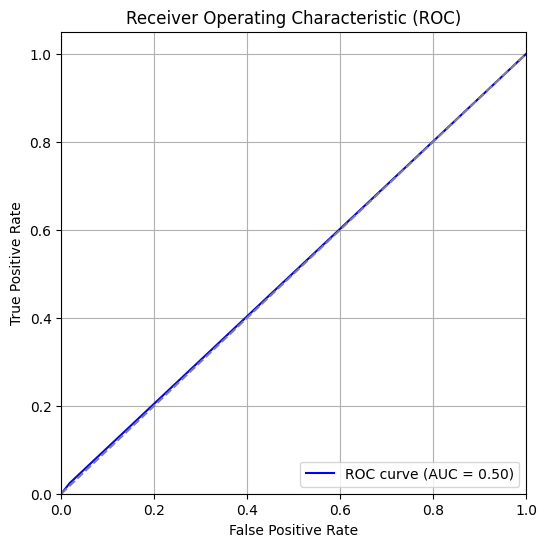

In [10]:
# --- ROC curve plot ---
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = roc_auc_score(y_true, y_score)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()